In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from algos.ppo import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining all constants

KAPPA = 25.0
CHI = 0.65 * 2 * jnp.pi
N_MAX = 163
N_DEFAULT = 30 # assume all measurement are till steady-state, ie around 10/kappa = 400ns
mu_default = jnp.sqrt(N_MAX / N_DEFAULT)
amp_default = 1/mu_default
GAMMA_PHOTON = 1/200
GAMMA_MEAS = 1/80
INIT_FID = 1 - 1e-4
SNR_SCALE = 5.0
STATE_STD = 1/jnp.sqrt(2)

In [4]:
def SS_meas_pF(
    amp, 
    ts
):
    '''
    Where amp is defined to take values between 0 and 1 like with IBMQ convention
    and ts is a sufficiently large linspace
    returns pF_res with shape (AMPS, TS)
    '''
    amp = amp.reshape(-1, 1)
    ts = ts.reshape(1, -1)
    amp_max = 0.5 * jnp.sqrt(N_MAX * (KAPPA ** 2 + CHI ** 2))
    photon = N_MAX * amp**2
    amp *= amp_max
    separation = (4 * amp * SNR_SCALE / (KAPPA ** 2 + CHI ** 2) 
                  * (CHI * (1. - jnp.exp(-0.5 * KAPPA * ts)) - 0.5 * KAPPA * CHI * ts * jnp.exp(-0.5 * KAPPA * ts)))
    separation_fid = 0.5 * (1. + erf(separation / (2 * jnp.sqrt(2) * STATE_STD)))
    decay_fid = INIT_FID * jnp.exp(-( 
        (GAMMA_PHOTON * photon + GAMMA_MEAS) * ts 
        - 4 * GAMMA_PHOTON * photon / KAPPA * (1. - jnp.exp(-0.5 * KAPPA * ts)) 
        + GAMMA_PHOTON * photon / KAPPA * (1. - jnp.exp(-KAPPA * ts)) 
        )
    )
    pF_res = -jnp.log10(1. - separation_fid * decay_fid)
    max_fidelity = jnp.max(pF_res, axis=-1)
    ts = ts.reshape(-1)
    time_of_max = ts[jnp.argmax(pF_res, axis=-1)]
    return pF_res, max_fidelity, time_of_max

In [5]:
ts = jnp.linspace(0., 0.4, 401)
amp_linspace = jnp.linspace(0.1, 1.0, 46)

batched_pF_res, batched_max_fidelity, batched_times = SS_meas_pF(amp_linspace, ts)

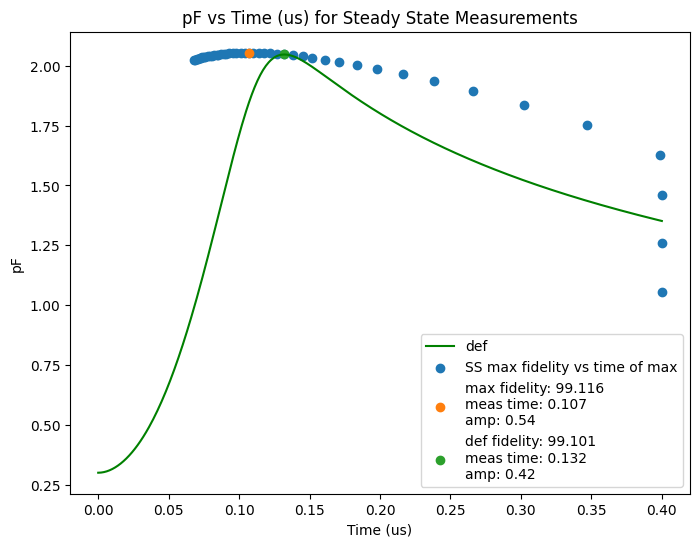

In [6]:
plt.figure(figsize=(8., 6.))
default_amp_ind = jnp.argmin(jnp.abs(amp_linspace - amp_default))
ss_fidelites = 1. - 10**(-batched_max_fidelity)

plt.plot(ts, batched_pF_res[default_amp_ind], label='def', color='green')
plt.scatter(batched_times, batched_max_fidelity, label='SS max fidelity vs time of max')
plt.scatter(
    batched_times[jnp.argmax(batched_max_fidelity)], 
    jnp.max(batched_max_fidelity), 
    label=f'max fidelity: {int(1e5*jnp.max(ss_fidelites)) / 1e3}\nmeas time: {int(1e3*batched_times[jnp.argmax(batched_max_fidelity)]) / 1e3}\namp: {int(1e3*amp_linspace[jnp.argmax(batched_max_fidelity)])/1e3}')
plt.scatter(
    batched_times[default_amp_ind], 
    batched_max_fidelity[default_amp_ind], 
    label=f'def fidelity: {int(1e5*jnp.max(ss_fidelites[default_amp_ind])) / 1e3}\nmeas time: {int(1e3*batched_times[default_amp_ind]) / 1e3}\namp: {int(1e3*amp_linspace[default_amp_ind])/1e3}')
plt.xlabel('Time (us)')
plt.ylabel('pF')
plt.title('pF vs Time (us) for Steady State Measurements')
plt.legend()
plt.show()

In [7]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 25.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/100
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 31
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 1e-2
snr_scale_factor = 5.0
gamma_I = 1/100
num_t1 = 8.0
photon_gamma = 1/200
init_fid = 1 - 1e-4

batchsize = 64
num_envs = 8
num_updates = 1000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 256,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 31
Actual Max Photons: 30.573151382405857


In [8]:
single_train = jit(PPO_make_train(config), static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    batchsize, 
    num_envs)
print(f"time taken: {time.time() - start}")

Starting a Run of 1000 Updates
global update: 100
mean batch reward: [22.94846449 22.99454311 22.92715747 22.95013258 22.89714237 22.97030281
 22.8685127  22.9476246 ]
mean batch pF: [2.47122764 2.4704743  2.46084671 2.46936673 2.4685418  2.47342994
 2.47114632 2.47047845]
mean batch photon: [12.82893944 13.43690968 13.24299717 13.54346275 13.32118893 13.27202034
 13.1217823  13.431427  ]
mean batch photon time: [0.16945751 0.169203   0.16709782 0.17022757 0.1687447  0.17002636
 0.17030714 0.16932095]
mean batch smoothness: [1.08192447e-04 9.68283069e-05 1.08136717e-04 1.00361163e-04
 1.20470231e-04 1.39499410e-04 1.37706894e-04 1.15480367e-04]
max reward obtained: [23.12072882 23.12319909 23.12758765 23.12855314 23.13488723 23.119268
 23.1370042  23.12721445]
pF at max: [2.47461894 2.47800553 2.4710252  2.47694817 2.47328272 2.47569592
 2.47843254 2.47662292]
photon at max: [16.05899048 11.69655228  9.41362476 12.77103329 12.49482822 11.98484707
 10.95590401 14.78699398]
photon time o

In [9]:
# Extracting Results

metrics = single_result["metrics"]

max_actions = metrics["action of max"]
max_rewards = metrics["max reward obtained"]
max_photons = metrics["photon at max"]
max_pFs = metrics["pF at max"]
max_times = metrics["photon time of max"]
max_smoothness = metrics["smoothness at max"]
mean_rewards = metrics["mean batch reward"]
mean_pFs = metrics["mean batch pF"]
mean_photons = metrics["mean batch photon"]
mean_photon_times = metrics["mean batch photon time"]
mean_smoothness = metrics["mean batch smoothness"]
std_reward = metrics["std batch reward"]

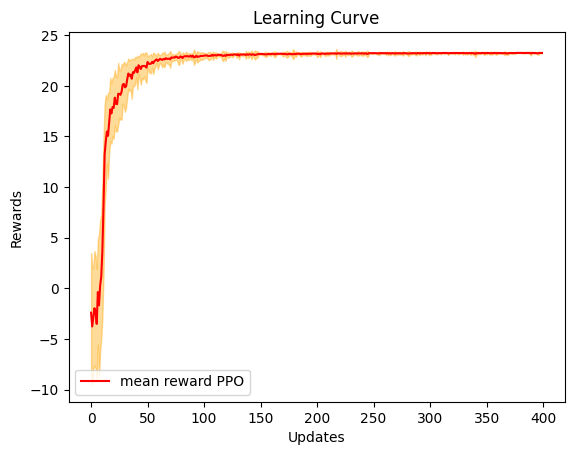

In [12]:
env_ind = 0
update_plot = 400

x = np.arange(update_plot)
m_plot = mean_rewards[:update_plot, env_ind]
s_plot = std_reward[:update_plot, env_ind]

plt.plot(x, m_plot, label='mean reward PPO', color='red')
plt.fill_between(x, m_plot - s_plot, m_plot + s_plot, color='orange', alpha=0.4)
plt.legend()
plt.xlabel('Updates')
plt.ylabel('Rewards')
plt.title('Learning Curve')
plt.show()

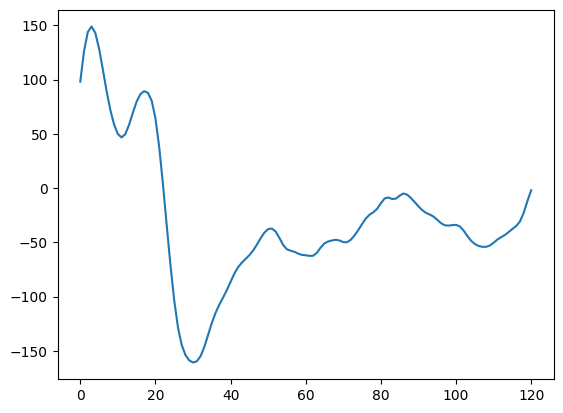

In [25]:
plt.plot(max_actions[480,env_ind])
plt.show()